In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision


/Users/fmunting/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/fmunting/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


**Data Pre-Processing**

In [2]:
data_dir = '../data/EuroSAT_RGB'
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = dataset.classes



**Setting up the Classifier**

Epoch 1/10, Loss: 0.8615645486778684


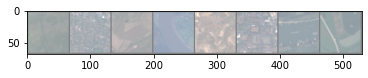

Predicted: Pasture, Residential, HerbaceousVegetation, Pasture, PermanentCrop, Residential, River, Pasture
Epoch 2/10, Loss: 0.7380771430774972
Epoch 3/10, Loss: 0.6562496197223663
Epoch 4/10, Loss: 0.5976777089304394
Epoch 5/10, Loss: 0.5559444667454119
Epoch 6/10, Loss: 0.5126968381360725


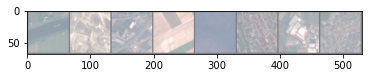

Predicted: River, PermanentCrop, Industrial, AnnualCrop, HerbaceousVegetation, Residential, Industrial, Residential
Epoch 7/10, Loss: 0.46517838105007453
Epoch 8/10, Loss: 0.4358168726717984
Epoch 9/10, Loss: 0.3978083880411254
Epoch 10/10, Loss: 0.375247229580526


In [3]:
testiter = iter(test_loader)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 11)  # 11 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for images, labels in train_loader:
    optimizer.zero_grad()
    predictions = model(images)
    loss = criterion(predictions, labels)
    loss.backward()
    optimizer.step()

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')
    if epoch % 5 == 0:
        with torch.no_grad():
            # Show a sample of images from the test data and model's predictions
                test_images, test_labels = testiter.__next__()
                test_images, test_labels = test_images.to(device), test_labels.to(device)
                imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
                test_outputs = model(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)
                predicted_classes = [class_names[i] for i in predicted.cpu().numpy()]
                print('Predicted:', ', '.join(predicted_classes))

**Model Testing**

Test Accuracy: 0.8294


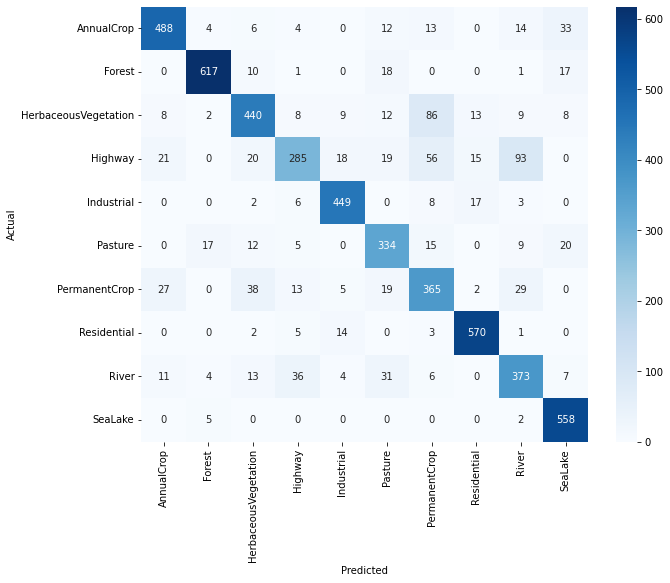

In [4]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Conclusion**

Our model has a test accuracy of approximately 80%. The confusion matrix shown above demonstrates that a large number of the misclassifications occur between HerbaceuousVegetation and PermanentCrop, as well as between Highway and River. Rivers and highways may look similar from an aerial view, and the differences between vegetation and permanent crop may be too subtle for our model to pick up. The model outputted a number of sample images with their predicted classifications. It is easy to see how the model could become "confused"; 

*Model Explanation*
Our model has two convolutional layers and two fully connected layers. We used ReLU as our activation function and performed max pooling to reduce the number of spatial dimensions between layers.

log_softmax() is used to convert the outputs of our function into log-probabilities that are distributed amongst the 11 image classes (the sub-directories in our given input). We chose to run our model for 10 epochs as this took approximately 20 minutes to run and we felt an 80% test accuracy was sufficient for our classification purposes. We also ran the model for 20 epochs; however, this only led to a increase in accuracy of 2%. We could have continued passing our data through our model in order to have our loss approach zero, but we wanted to optimize for both model performance and run time.